In [ ]:
from google.colab import drive

drive.mount("/content/drive")
!ln -s "/content/drive/My Drive/clean_reviews" "/content/clean_reviews"
#!ln -s "/content/drive/My Drive/aws_keys.py" "/content/aws_keys.py"
!ln -s "/content/drive/My Drive/glove.6B.100d.txt" "/content/glove_100d_vectors"

### Importing modules

In [ ]:
import glob
import os
#import io
#import boto3
#import gzip
#from aws_keys import ACCESS_KEY, SECRET_KEY

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
%load_ext tensorboard

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Write some functions


In [ ]:
def download_file(access_key, secret_key, bucket_name, key_name, output_file):
  s3 = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key)
  s3.download_file(bucket_name, key_name, output_file)

def read_zip_file(output_file, max_rows):
 return pd.read_csv(output_file, sep='\t', nrows=max_rows, engine='python', quoting=3, usecols=['review_body', 'star_rating'])

def remove_punctuation(row):
    return row.lower().replace('[^\sa-zA-Z0-9]', '').replace("<br />", " ").replace("&#34;", "").strip()

In [ ]:
def read_csv_all(folder_name, max_rows):
    df = (pd.read_csv(file_name, names=['review', 'rating'], nrows=max_rows) for file_name in glob.glob(folder_name + '/' + '*.csv'))
    df = pd.concat(df).dropna()
    X = df.review.to_numpy()
    y = df.rating.to_numpy()
    return X, y

In [ ]:
def tokenize_words(max_words, texts, tk_mode='tfidf'):
  tokenize = Tokenizer(num_words=max_words)
  tokenize.fit_on_texts(texts)
  return tokenize, tokenize.texts_to_matrix(texts, mode=tk_mode) # tfidf reduces importance of common words 

In [ ]:
def download_glove(filename):
  embedding = {}
  with open(filename, 'r') as f:
    for line in f:
      word = line.split()[0]
      coeffs = np.asarray(line.split()[1:], dtype='float32')
      embedding[word] = coeffs
  return embedding

def build_emedding_matrix(word_index, max_words, embedding_dim, embeddings_index):
  embedding_matrix = np.zeros((max_words, embedding_dim))
  for word, idx in word_index.items():
    if idx < max_words:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
  return embedding_matrix

In [ ]:
def plot_model_results(history):
  fig, ax = plt.subplots(1, 2, figsize=(10, 3))
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  ax[0].plot(epochs, loss, 'b--', label='Training loss')
  ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
  ax[0].set_title('Training and validation loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[0].grid(True)

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  
  ax[1].plot(epochs, acc, 'b--', label='Training acc')
  ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
  ax[1].set_title('Training and validation accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()
  ax[1].grid(True)
  plt.tight_layout()

In [ ]:
def eval_model(X_test, y_test, target_model):
  y_pred = np.argmax(target_model.predict(X_test), axis=1) 
  y_true = np.argmax(y_test, axis=1)
  return y_pred, y_true

def print_results(X_test, y_test, num_labels, target_model):
  y_pred, y_true = eval_model(X_test, y_test, target_model)
  cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_labels)
  fig, ax = plt.subplots(figsize=(10, 4))
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", 
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
  ax.set_xlabel('Predicted values')
  ax.set_ylabel('Actual values')
  plt.show()
  
  class_acc = np.diag(cm)/np.sum(cm, axis=1)*100
  for i in range(num_labels):
    print('Accuracy for class {0} is {1:.2f}%'.format(i+1, class_acc[i]))
  print('Mean class accuracy is {:.2f}%'.format(np.mean(class_acc)))
  print('Test accuracy is {:.2f}%'.format(np.sum(np.diag(cm))/np.sum(np.sum(cm, axis=1))*100))
  
  recall = (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])/(np.sum(cm, axis=1)[0] + np.sum(cm, axis=1)[1])*100
  print('The recall for bad reviews is {:.2f}%'.format(recall))

def misclassified_revs(X_test, y_test, model, X_test_texts, num):
  y_pred, y_true = eval_model(X_test, y_test, model)

  print('Good reviews wrongly classified as bad:\n')
  for sentence in X_test_texts[np.argwhere((y_pred == 0)&(y_true == 4))[:num]]:  
    print(sentence[0])
  print('\nBad reviews wrongly classified as good:\n')
  for sentence in X_test_texts[np.argwhere((y_pred == 4)&(y_true == 0))[:num]]:  
    print(sentence[0])

### Download data 

In [ ]:
# keyfile = 'aws_keys'
# bucket = "amazon-reviews-pds"
# key = "tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz"
# output_file = 'reviews.gz'
max_rows = 100000 # shrink data size to manageable 

# download_file(ACCESS_KEY, SECRET_KEY, bucket, key, output_file)
# df = read_zip_file(output_file, max_rows).dropna()
# X = df.review_body.apply(remove_punctuation).to_numpy()
# y = df.star_rating.to_numpy()

X, y = read_csv_all('clean_reviews', max_rows) 

### Train 1st model -  Simple NN 

In [ ]:
# tokenize features and encode labels to numerical
max_words = 10000

tokenizer, X_tokenized = tokenize_words(max_words, X) # uses TF-IDF tokenization
y_encoded = to_categorical(y-1, num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y_encoded, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 10000) (70000, 5)
(30000, 10000) (30000, 5)


In [ ]:
# define function vars: optimizer, loss function, metrics to measure etc.
optimizer_function = 'adam' # difference between adam, rmsprop, etc?
loss_function = 'categorical_crossentropy'
model_metrics = ['accuracy']
BATCH_SIZE = 512
validation_split = 0.1
steps = 50
num_labels = 5

# define callbacks for tensorboard logs and early stopping
tensorboard_callback = TensorBoard(log_dir='logs/simplenn/no_reg')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.05, patience=10)

# model implementation
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(max_words,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_labels, activation='softmax'))
model.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

val_num = round(len(X_train)*(1 - validation_split))
history = model.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

Epoch 00012: early stopping


Traning results:


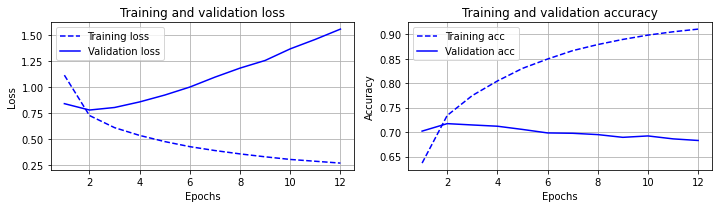

In [ ]:
print('Traning results:')
plot_model_results(history)

We can see that overfitting is becoming an issue- training accuracy increasing while validation accuracy is decreasing. We will explore 2 ways to improve overfitting. The first one is by adding L2 regularization. The second one is by adding dropout.

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/simplenn/reg_l2')

model_reg = models.Sequential()
model_reg.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(max_words,)))
model_reg.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_reg.add(layers.Dense(num_labels, activation='softmax'))
model_reg.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_reg = model_reg.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

Epoch 00014: early stopping


Traning results:


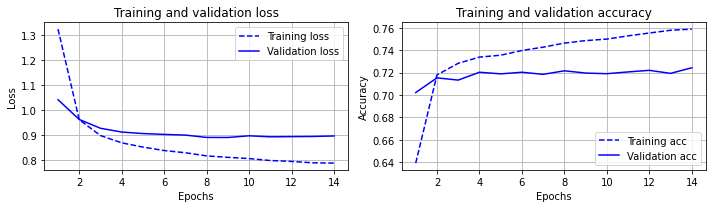

In [ ]:
print('Traning results:')
plot_model_results(history_reg)

Epoch 00012: early stopping
Traning results:


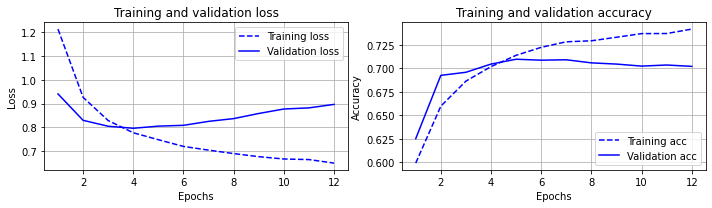

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/simplenn/with_dropout')

model_dout = models.Sequential()
model_dout.add(layers.Dense(16, activation='relu', input_shape=(max_words,)))
model_dout.add(layers.Dropout(0.4))
model_dout.add(layers.Dense(16, activation='relu'))
model_dout.add(layers.Dropout(0.4))
model_dout.add(layers.Dense(num_labels, activation='softmax'))
model_dout.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_dout = model_dout.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_dout)

Choosing model with l2 reg - Test results:


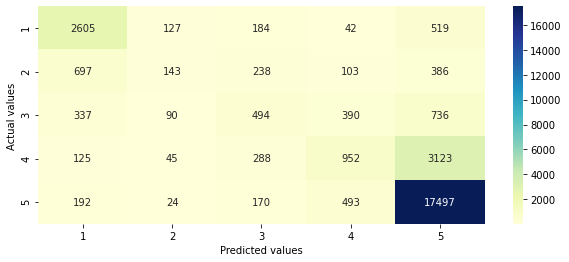

Accuracy for class 1 is 74.92%
Accuracy for class 2 is 9.13%
Accuracy for class 3 is 24.13%
Accuracy for class 4 is 21.00%
Accuracy for class 5 is 95.22%
Mean class accuracy is 44.88%
Test accuracy is 72.30%
The recall for bad reviews is 70.82%


In [ ]:
print('Choosing model with l2 reg - Test results:')
print_results(X_test, y_test, num_labels, model_reg)

In [ ]:
_, xtest_texts, _, _ = train_test_split(X, y, test_size=0.3, random_state=0)
misclassified_revs(X_test, y_test, model_reg, xtest_texts, 5)

Good reviews wrongly classified as bad:

i guess i should have tested this but never got around to it until today well it worked like a champ for the time i had  no power about 45 minutes it kept my dvr and wifi router going for six security cameras the router powers the cameras so i dont know if that meant this unit provided the power but it must have because the whole house was without electricity for that time my cameras did not lose a minute i think by the time the power came back on it still had a good bit of energy left i should have paid closer attention but there was a lot of ac work being done in my  house  i would recommend this brand i usually buy apc back up batteries which also work well but tried this one after reading glowing reviews and noticing how much the apc went up in price  i would get this again and am happy with my purchase
i purchased this to work with the chromecast unit i purchased this item was ideal for what was needed too bad the chromecast has not proven 

### Using n-grams


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0, max_features=max_words)
X_ngrams = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ngrams.toarray(), y_encoded, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 10000) (70000, 5)
(30000, 10000) (30000, 5)


Epoch 00013: early stopping
Traning results:


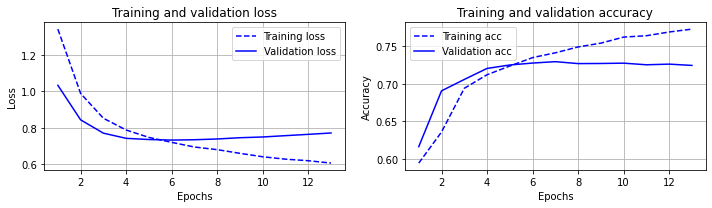

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/simplenn/with_ngrams')

model_ngrams = models.Sequential()
model_ngrams.add(layers.Dense(16, activation='relu', input_shape=(max_words,)))
model_ngrams.add(layers.Dropout(0.4))
model_ngrams.add(layers.Dense(16, activation='relu'))
model_ngrams.add(layers.Dropout(0.4))
model_ngrams.add(layers.Dense(num_labels, activation='softmax'))
model_ngrams.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_ngrams = model_ngrams.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])
print('Traning results:')
plot_model_results(history_ngrams)

Test results:


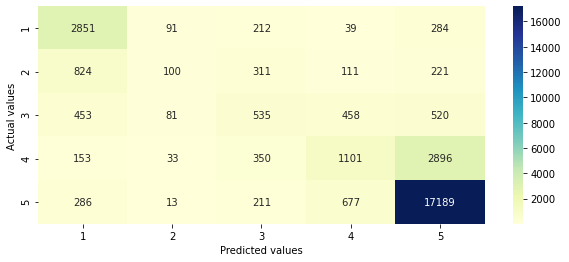

Accuracy for class 1 is 82.00%
Accuracy for class 2 is 6.38%
Accuracy for class 3 is 26.14%
Accuracy for class 4 is 24.29%
Accuracy for class 5 is 93.54%
Mean class accuracy is 46.47%
Test accuracy is 72.59%
The recall for bad reviews is 76.65%


In [ ]:
print('Test results:')
print_results(X_test, y_test, num_labels, model_ngrams)

In [ ]:
misclassified_revs(X_test, y_test, model_ngrams, xtest_texts, 5)

Good reviews wrongly classified as bad:

i just very satisfy with my choicebut the package was broken when it arrivalbut the product is very great
i purchased this to work with the chromecast unit i purchased this item was ideal for what was needed too bad the chromecast has not proven to be what id hoped
new came with its own charging cable and head phones both new if u dont want it scratched get a cover and dont place it in your pocket with anything else the back part is easily scratched mine came scratched even inside of packaging
charged up my phone fast
everybody should have this

Bad reviews wrongly classified as good:

well i wish i had a chance to try these head phones out but all i got was the box the package came sealed and when i opened it this is what i found
i ordered because it said it was compatible with the beats by dre detox headphones which it isnt for the detox headphones you need one cord that has two in one a y cable this is just the classic cable
the slightest vib

### Using word embeddings

Word embeddings create denser matrices and aims to learn relationships between similar words. It transforms words to word vectors. This can either be learned from data during training or we can use pretrained embeddings. Below, we will use a pretrained word embedding known as GloVe

In [ ]:
max_len = 100

sequences = tokenizer.texts_to_sequences(X)
data = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(data, y_encoded, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(70000, 100) (30000, 100)
(70000, 5) (30000, 5)


In [ ]:
embedding_dim = 100

embeddings_idx = download_glove('glove_100d_vectors')
print('There are {} word vectors in this pre trained set.'.format(len(embeddings_idx)))

embedding_matrix = build_emedding_matrix(tokenizer.word_index, max_words, embedding_dim, embeddings_idx)
print('Shape of embedding matrix: {}'.format(embedding_matrix.shape))

There are 400000 word vectors in this pre trained set.
Shape of embedding matrix: (10000, 100)


Epoch 00020: early stopping
Traning results:


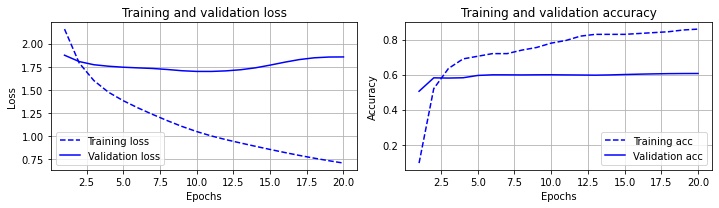

In [ ]:
# Using pretrained word embedding
training_samp = 200
tensorboard_callback = TensorBoard(log_dir='logs/simplenn/with_glove')

model_glove = models.Sequential()
model_glove.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model_glove.add(layers.Flatten())
model_glove.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_glove.add(layers.Dense(num_labels, activation='softmax'))
model_glove.layers[0].set_weights([embedding_matrix])
model_glove.layers[0].trainable = False

model_glove.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_glove = model_glove.fit(X_train[:training_samp], y_train[:training_samp], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[training_samp:], y_train[training_samp:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_glove)

Epoch 00016: early stopping
Traning results:


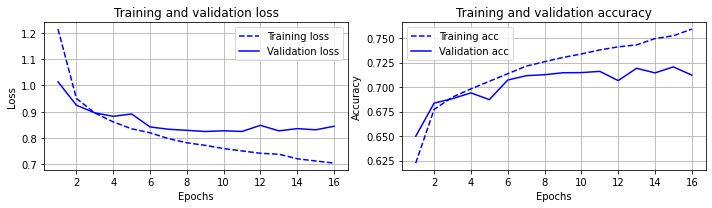

In [ ]:
# Training embeddings with model 
tensorboard_callback = TensorBoard(log_dir='logs/simplenn/with_word_embedding')

model_embed = models.Sequential()
model_embed.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model_embed.add(layers.Flatten())
model_embed.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.03), activation='relu'))
model_embed.add(layers.Dense(num_labels, activation='softmax'))

model_embed.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_embed = model_embed.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_embed)

Choosing model with own trained embeddings - Test results:


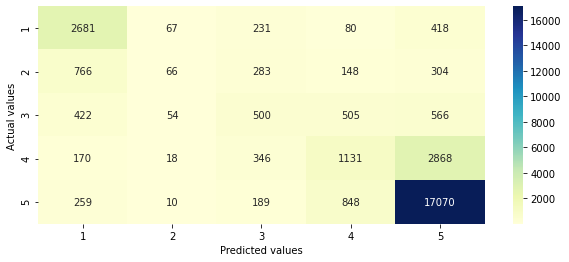

Accuracy for class 1 is 77.11%
Accuracy for class 2 is 4.21%
Accuracy for class 3 is 24.43%
Accuracy for class 4 is 24.95%
Accuracy for class 5 is 92.89%
Mean class accuracy is 44.72%
Test accuracy is 71.49%
The recall for bad reviews is 70.98%


In [ ]:
print('Choosing model with own trained embeddings - Test results:')
print_results(X_test, y_test, num_labels, model_embed)

When there is ample data available, training your own word embeddings performs better than using pre-trained word embeddings. The GloVe model starts to overfit significantly due to the small number of training samples. The model with a trainable embedding layer performs pretty well due to the high number of training samples. 


### Train 2nd model - Single layer RNN
The biggest issue with our classification is that the model has no memory of previous words in the sentence e.g. 'good' and 'not good' is seen as the same. We can use recurrent neural networks(RNN) to solve this issue.

In [ ]:
max_len = 500

data = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(data, y_encoded, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(70000, 500) (30000, 500)
(70000, 5) (30000, 5)


Epoch 00015: early stopping
Traning results:


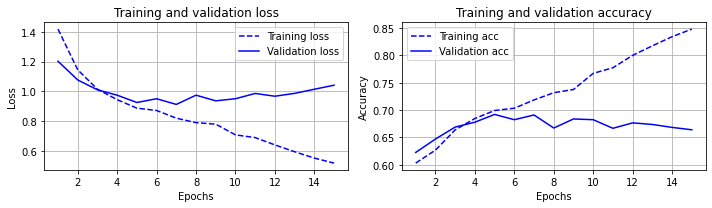

In [ ]:
validation_split = 0.2
tensorboard_callback = TensorBoard(log_dir='logs/rnn/singlernn')

model_rnn = models.Sequential()
model_rnn.add(layers.Embedding(max_words, 32))
model_rnn.add(layers.SimpleRNN(32, kernel_regularizer=regularizers.l2(0.01)))
model_rnn.add(layers.Dense(num_labels, activation='softmax'))

model_rnn.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

val_num = round(len(X_train)*(1 - validation_split))
history_rnn = model_rnn.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_rnn)

### Train 3rd model - Single LSTM
The problem with RNN is that it is unable to retain information from previous timesteps due to what is known as the vanishing gradient problem. This is because the change in error with respect to weights in a RNN is also dependent on the change in state at time t with respect to the change in state at previous timesteps. At each timestep, the state is multipled by a weight. Hence if the weight is small, it starts decreasing with each back propoagation step and eventually vanishes which makes updating the weights very difficult. The model than becomes untrainable.


Epoch 00019: early stopping
Traning results:


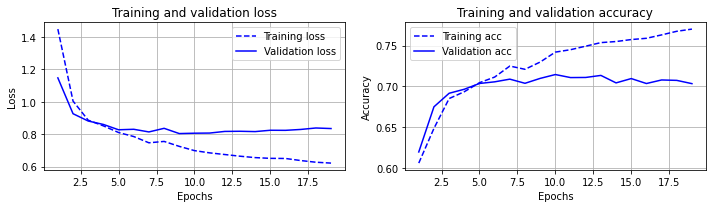

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/rnn/singlelstm')

model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(max_words, 32))
model_lstm.add(layers.LSTM(32, kernel_regularizer=regularizers.l2(0.01)))
model_lstm.add(layers.Dense(num_labels, activation='softmax'))

model_lstm.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_lstm = model_lstm.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_lstm)

### Train 4th model - Single GRU
GRUs are less complex and train quicker than LSTMs while also dealing with the vanishing gradient problem of RNNs. GRUs don't have an output gate which means they don't have the internal memory of the LSTM holding the carry. They use a reset and update gate to directly output the next hidden state. 

Epoch 00013: early stopping
Traning results:


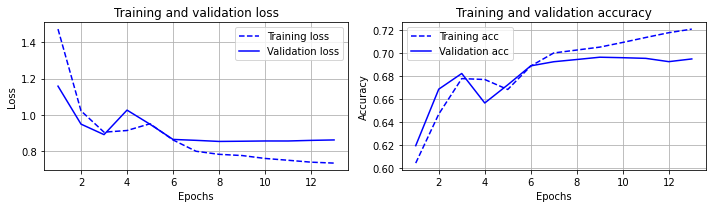

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/rnn/singlegru')

model_gru = models.Sequential()
model_gru.add(layers.Embedding(max_words, 32))
model_gru.add(layers.GRU(32, kernel_regularizer=regularizers.l2(0.01)))
model_gru.add(layers.Dense(num_labels, activation='softmax'))

model_gru.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_gru = model_gru.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_gru)

### Train 5th model - 1D CovNet
Convolutional neural networks are generally used for image processing tasks but 1D CNNs can be useful for sequence processing where time is treated as a dimension. CNNs work by finding patterns in sequences by convolving the sequence with a filter.

Epoch 00018: early stopping
Traning results:


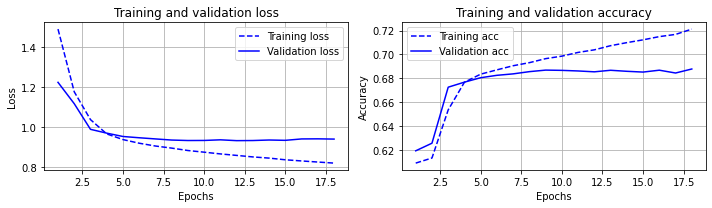

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/cnn/simplecnn')

model_cnn = models.Sequential()
model_cnn.add(layers.Embedding(max_words, 32))
model_cnn.add(layers.Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.MaxPooling1D(5))
model_cnn.add(layers.Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(num_labels, activation='softmax'))

model_cnn.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_cnn = model_cnn.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_cnn)

### Does chronology matter? Looking at Bidirectional RNNs

Epoch 00015: early stopping
Traning results:


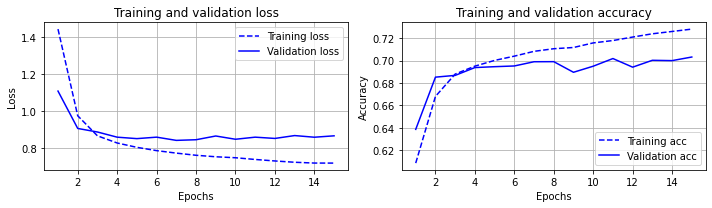

In [ ]:
#training model on reverse data
rev_sequences = [x[::-1] for x in sequences]
rev_data = pad_sequences(rev_sequences, maxlen=max_len)
X_train_rev, _, y_train_rev, _ = train_test_split(rev_data, y_encoded, test_size=0.3, random_state=0)

model_reverse = models.Sequential()
model_reverse.add(layers.Embedding(max_words, 32))
model_reverse.add(layers.GRU(32, kernel_regularizer=regularizers.l2(0.01)))
model_reverse.add(layers.Dense(num_labels, activation='softmax'))

model_reverse.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_rev = model_reverse.fit(X_train_rev[:val_num], y_train_rev[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train_rev[val_num:], y_train_rev[val_num:]), verbose=0, callbacks=[es])

print('Traning results:')
plot_model_results(history_rev)

The performance is similar to the model fit on the non reversed dataset which proves that the chronological order of words in a sentence is not important. However, training the model on the reversed sequence likely produces a different set of representations which could be used along with the model trained on the non reversed sequence to produce a better model (this is known as ensembling and the more different the representations the better). We can implement this using bidirectional RNNs which look at the sequence in both a chronological and anti chronological order.

Epoch 00013: early stopping
Traning results:


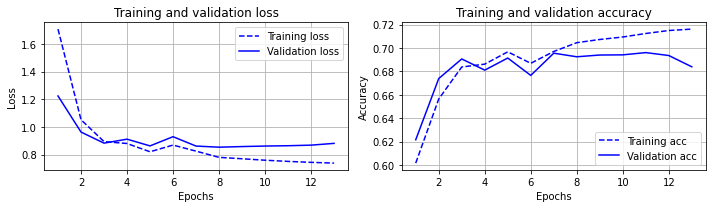

In [ ]:
model_bi_gru = models.Sequential()
model_bi_gru.add(layers.Embedding(max_words, 32))
model_bi_gru.add(layers.Bidirectional(layers.GRU(32, kernel_regularizer=regularizers.l2(0.01))))
model_bi_gru.add(layers.Dense(num_labels, activation='softmax'))

model_bi_gru.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_bi_gru = model_bi_gru.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es])

print('Traning results:')
plot_model_results(history_bi_gru)

### Train 6th model - CNN + LSTM

Epoch 00015: early stopping
Traning results:


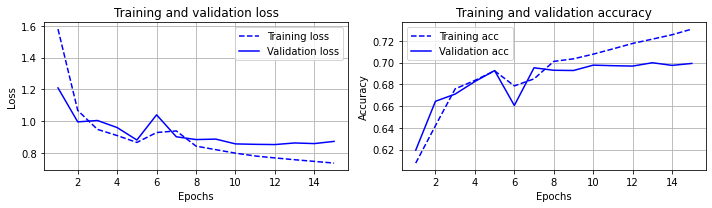

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/complex_models/cnn_lstm')

model_cnn_lstm = models.Sequential()
model_cnn_lstm.add(layers.Embedding(max_words, 32))
model_cnn_lstm.add(layers.Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_lstm.add(layers.MaxPooling1D(2))
model_cnn_lstm.add(layers.LSTM(32, kernel_regularizer=regularizers.l2(0.01)))
model_cnn_lstm.add(layers.Dense(num_labels, activation='softmax'))

model_cnn_lstm.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_cnn_lstm = model_cnn_lstm.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_cnn_lstm)

### Train 7th model - Stacked LSTM layers

Epoch 00013: early stopping
Traning results:


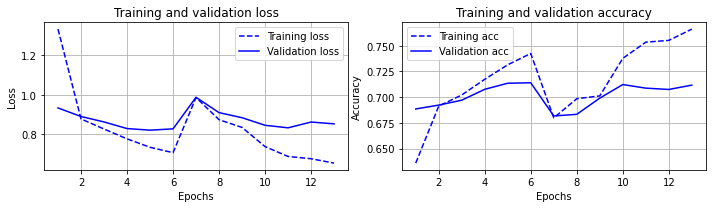

In [ ]:
tensorboard_callback = TensorBoard(log_dir='logs/complex_models/stacked_lstm')

model_complex = models.Sequential()
model_complex.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model_complex.add(layers.LSTM(256, kernel_regularizer=regularizers.l2(0.002), return_sequences=True))
model_complex.add(layers.LSTM(256, kernel_regularizer=regularizers.l2(0.002)))
model_complex.add(layers.Dense(num_labels, activation='softmax'))

model_complex.compile(optimizer=optimizer_function, loss=loss_function, metrics=model_metrics)

history_complex = model_complex.fit(X_train[:val_num], y_train[:val_num], epochs=steps, batch_size=BATCH_SIZE, 
                    validation_data=(X_train[val_num:], y_train[val_num:]), verbose=0, callbacks=[es, tensorboard_callback])

print('Traning results:')
plot_model_results(history_complex)

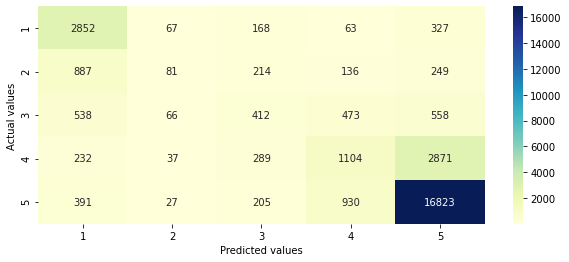

Accuracy for class 1 is 82.02%
Accuracy for class 2 is 5.17%
Accuracy for class 3 is 20.13%
Accuracy for class 4 is 24.35%
Accuracy for class 5 is 91.55%
Mean class accuracy is 44.64%
Test accuracy is 70.91%
The recall for bad reviews is 77.06%


In [ ]:
print_results(X_test, y_test, num_labels, model_complex)

In [ ]:
y_pred, y_true = eval_model(X_test, y_test, model_complex)

print('Good reviews wrongly classified as bad:\n')
for sentence in xtest_texts[np.argwhere((y_pred == 0)&(y_true == 4))[:5]]:  
  print(sentence[0])
print('\nBad reviews wrongly classified as good:\n')
for sentence in xtest_texts[np.argwhere((y_pred == 4)&(y_true == 0))[:5]]:  
  print(sentence[0])

Good reviews wrongly classified as bad:

packaging was smartly done with all materials clearly labeled  directions were exceptionally clear and the product itself was fantastic  i cannot recommend this company enough
after a number of returned products by other manufacturers  this one is a delight easy to set up sound  even from mp3s is spectacular should have looked at this one first
i purchased this to work with the chromecast unit i purchased this item was ideal for what was needed too bad the chromecast has not proven to be what id hoped
new came with its own charging cable and head phones both new if u dont want it scratched get a cover and dont place it in your pocket with anything else the back part is easily scratched mine came scratched even inside of packaging
antenna shipped on time and functions well  i would recommend this selleron the product  not really all worked up about the channels it attracts but ive never been one for regular daytime tv religious shows spanish chan